In [18]:
from visualizer.main import Visualizer

# Rysowanie triangulacji

In [19]:
def convert_to_lines(points):
    lines = []
    for p in range(len(points)-1):
        lines.append((points[p], points[p+1]))
    lines.append((points[-1], points[0]))
    return lines

def draw_triangulation(vertices, triangles, vis):
    for index1, index2, index3 in triangles:
        segment1 = (vertices[index1], vertices[index2])
        segment2 = (vertices[index2], vertices[index3])
        segment3 = (vertices[index3], vertices[index1])
        vis.add_line_segment((segment1, segment2, segment3), color="black")
    return vis

# Ładowanie triangulacji z/do pliku

In [20]:
def load_from_file(filename):
    vertices = []
    triangles = []
    with open(f"triangulations/{filename}", "r") as f:
        text = f.read().strip()
    for line in text.splitlines():
        row_elements = line.split()
        try:
            if row_elements[0] == "v":
                vertices.append((float(row_elements[1]), float(row_elements[2])))
            elif row_elements[0] == "t":
                triangles.append((int(row_elements[1]), int(row_elements[2]), int(row_elements[3])))
            else:
                print("Wrong row type - it should be either 't' for triangle indices or 'v' for vertices")
                break
        except ValueError:
            print("Vertices' coordinates should be floats and triangle indices should be integers")
            break
        except IndexError:
            print("Vertex's row should contain only a single character 'v' and two float numbers separated by spaces. Triangle's row should contain character 't' and three numbers separated by spaces.")
            break
    return vertices, triangles

def save_to_file(filename, vertices, triangles):
    lines = []
    for x, y in vertices:
        lines.append(f"v {x} {y}")
    for a, b, c in triangles:
        lines.append(f"t {a} {b} {c}")
    text = "\n".join(lines)
    with open(f"triangulations/{filename}", "w") as f:
        f.write(text)

# Implementacja struktury Half Edge

In [21]:
class HalfEdge:
    def __init__(self, origin, face):
        self.origin = origin
        self.face = face
        self.twin = None
        self.prev = None
        self.next = None
        self.visualizer_figure = None
        
    def add_to_visualizer(self, vis, vertices):
        start = self.origin
        end = self.twin.origin
        self.visualizer_figure = vis.add_line_segment((vertices[start].coords, vertices[end].coords), color="blue")
    
    def remove_from_visualizer(self, vis):
        vis.remove_figure(self.visualizer_figure)
        self.visualizer_figure = None

class Vertex:
    def __init__(self, coords):
        self.coords = coords
        self.half_edge = None


class Face:
    def __init__(self, indices):
        self.indices = indices
        self.half_edge = None


class HalfEdgeGraph:
    
    def twin_edges(self, edge1, edge2):
        edge1.twin = edge2
        edge2.twin = edge1
    
    def connect_edges(self, edges):
        for i in range(len(edges)):
            edges[i].next = edges[(i + 1) % len(edges)]
        for i in range(len(edges)):
            edges[i].prev = edges[i - 1]
    
    def edges_overlapping(self, index1, index2, index3):
        edges = ((index1, index2), (index2, index3), (index3, index1))
        for edge in edges:
            if edge in self.edges:
                return True
        return False
    
    def connect_twins(self):
        original_keys = [key for key in self.edges.keys()]
        exterior_ends = {}
        for key in original_keys:
            reversed_key = (key[1], key[0])
            if reversed_key not in self.edges:
                exterior_edge = HalfEdge(reversed_key[0], None)
                self.edges[reversed_key] = exterior_edge
                exterior_ends[reversed_key[0]] = reversed_key[1]
            self.twin_edges(self.edges[key], self.edges[reversed_key])
        return exterior_ends
        
    def connect_cycle(self, exterior_ends):
        start = next((key for key in exterior_ends.keys()))
        cycle = [(start, exterior_ends[start]),]
        current = exterior_ends[start]
        while current != start:
            cycle.append((current, exterior_ends[current]))
            current = exterior_ends[current]
        self.connect_edges([self.edges[edge] for edge in cycle])
        
    def create_edges(self):
        for face_index, face in enumerate(self.faces):
            index1, index2, index3 = face.indices
            if not self.edges_overlapping(index1, index2, index3):
                edges_vertices = ((index1, index2), (index2, index3), (index3, index1))
            else:
                edges_vertices = ((index1, index3), (index3, index2), (index2, index1))
            edges = []
            for vertex1, vertex2 in edges_vertices:
                edge = HalfEdge(vertex1, face_index)
                edges.append(edge)
                if self.vertices[vertex1].half_edge is None:
                    self.vertices[vertex1].half_edge = edge
                if self.faces[face_index].half_edge is None:
                    self.faces[face_index].half_edge = edge
                self.edges[(vertex1, vertex2)] = edge
            self.connect_edges(edges)
        exterior_ends = self.connect_twins()
        self.connect_cycle(exterior_ends)
    
    def check_layers(self, layers, index):
        for layer in layers:
            if index in layer:
                return True
        return False
    
    def get_color(self, level):
        if level == 0:
            return "red"
        if level == 1:
            return "orange"
        if level == 2:
            return "yellow"
        return "green"        
    
    def incidental_vertices_visualize(self, vertex_index, levels, visualizer):
        layers = [{vertex_index,},]
        visualizer.add_point(self.vertices[vertex_index].coords, color=self.get_color(0))
        for i in range(1, levels + 1):
            layers.append(set())
            for index in layers[i-1]:
                start_vertex = self.vertices[index]
                start_edge = start_vertex.half_edge
                current_edge = start_edge
                while True:
                    current_edge = current_edge.prev
                    current_edge.add_to_visualizer(visualizer, self.vertices)
                    current_edge.remove_from_visualizer(visualizer)
                    if not self.check_layers(layers, current_edge.origin):
                        layers[i].add(current_edge.origin)
                        visualizer.add_point(self.vertices[current_edge.origin].coords, color=self.get_color(i))
                    current_edge = current_edge.twin
                    if current_edge is start_edge:
                        break
        return layers, visualizer
    
    def incidental_vertices(self, vertex_index, levels):
        layers = [{vertex_index,},]
        for i in range(1, levels + 1):
            layers.append(set())
            for index in layers[i-1]:
                start_vertex = self.vertices[index]
                start_edge = start_vertex.half_edge
                current_edge = start_edge
                while True:
                    current_edge = current_edge.prev
                    if not self.check_layers(layers, current_edge.origin):
                        layers[i].add(current_edge.origin)
                    current_edge = current_edge.twin
                    if current_edge is start_edge:
                        break
        return layers
    
    def incidental_triangles_visualize(self, face_index, levels, visualizer):
        layers = [{face_index,},]
        coords = [self.vertices[index].coords for index in self.faces[face_index].indices]
        visualizer.add_polygon(coords, color=self.get_color(0))
        for i in range(1, levels+1):
            layers.append(set())
            for index in layers[i-1]:
                face = self.faces[index]
                start_edge = face.half_edge
                current_edge = start_edge
                while True:
                    current_edge.add_to_visualizer(visualizer, self.vertices)
                    current_edge.remove_from_visualizer(visualizer)
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        twin_face = self.faces[twin.face]
                        coords = [self.vertices[index].coords for index in twin_face.indices]
                        visualizer.add_polygon(coords, color=self.get_color(i))
                        layers[i].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
        return layers, visualizer
    
    def incidental_triangles(self, face_index, levels):
        layers = [{face_index,},]
        for i in range(1, levels+1):
            layers.append(set())
            for index in layers[i-1]:
                face = self.faces[index]
                start_edge = face.half_edge
                current_edge = start_edge
                while True:
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        layers[i].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
        return layers
    
    def seek_vertex_visualize(self, face_index, vertex_index, visualizer):
        visualizer.add_point(self.vertices[vertex_index].coords, color="red")
        layers = [{face_index,},]
        i = 0
        while True:
            layers.append(set())
            face_found = None
            for index in layers[i]:
                face = self.faces[index]
                
                coords = [self.vertices[index].coords for index in face.indices]
                visualizer.add_polygon(coords, color="yellow")

                start_edge = face.half_edge
                current_edge = start_edge
                while True:
                    current_edge.add_to_visualizer(visualizer, self.vertices)
                    current_edge.remove_from_visualizer(visualizer)
                    
                    if current_edge.origin == vertex_index:
                        face_found = self.faces[current_edge.face]
                        coords = [self.vertices[index].coords for index in face_found.indices]
                        visualizer.add_polygon(coords, color="green")
                        break
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        layers[i+1].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
                if not layers[i+1] or face_found is not None:
                    return face_found, visualizer
            i += 1
            
    def seek_vertex(self, face_index, vertex_index):
        layers = [{face_index,},]
        i = 0
        while True:
            layers.append(set())
            face_found = None
            for index in layers[i]:
                face = self.faces[index]
                start_edge = face.half_edge
                current_edge = start_edge
                while True:  
                    if current_edge.origin == vertex_index:
                        face_found = self.faces[current_edge.face]
                        break
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        layers[i+1].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
                if not layers[i+1] or face_found is not None:
                    return face_found
            i += 1

            
    def __init__(self, vertices, faces):
        self.vertices = [Vertex(v) for v in vertices]
        self.faces = [Face(f) for f in faces]
        self.edges = {}
        self.create_edges()


# Test operacji na strukturze Half Edge

In [22]:
points4, triangulation4 = load_from_file("sample_triangulation4.txt")
half_edges4 = HalfEdgeGraph(points4, triangulation4)

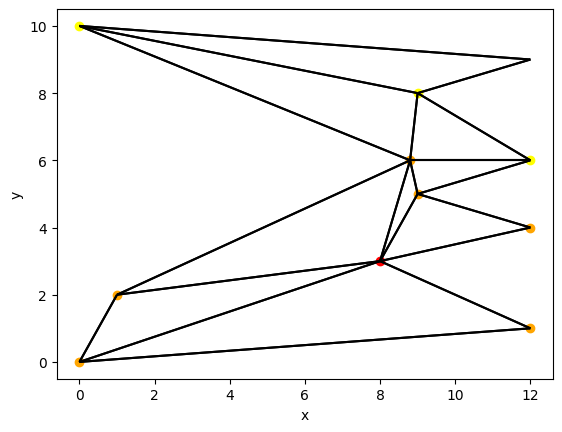

In [23]:
vis = Visualizer()
triangulation = triangulation4
points = points4
polygon = convert_to_lines(points)
vis.add_line_segment(polygon, color="black")
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines, color="black")
_, vis = half_edges4.incidental_vertices_visualize(2, 2, vis)
vis.show()

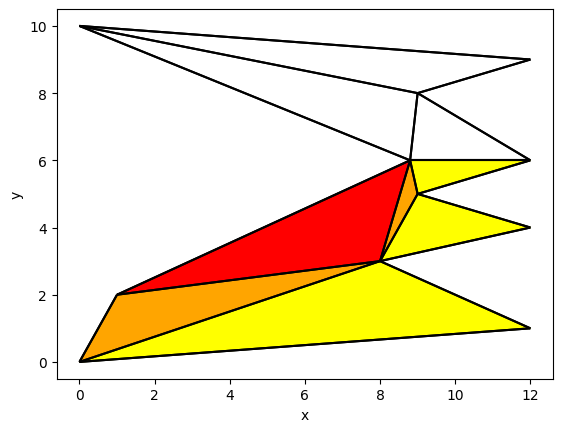

In [24]:
vis = Visualizer()
triangulation = triangulation4
points = points4
polygon = convert_to_lines(points)
vis.add_line_segment(polygon, color="black")
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines, color="black")
_, vis = half_edges4.incidental_triangles_visualize(2, 2, vis)
vis.show()

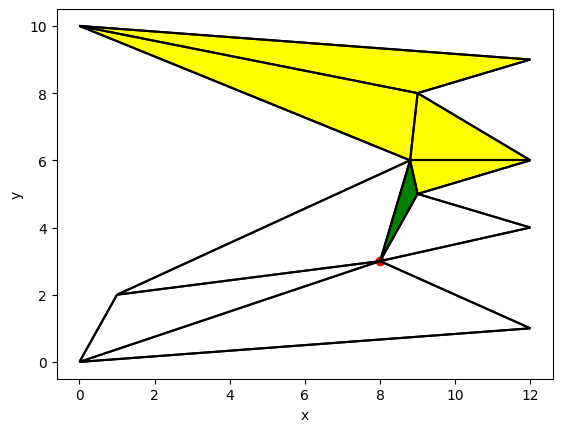

In [25]:
vis = Visualizer()
triangulation = triangulation4
points = points4
polygon = convert_to_lines(points)
vis.add_line_segment(polygon, color="black")
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines, color="black")
_, vis = half_edges4.seek_vertex_visualize(8, 2, vis)
vis.show()

# Przeszukiwanie incydentnych wierzchołków w zwykłej strukturze

Otoczenie jednowarstwowe wierzchołka 5 - {9, 4, 6}
Otoczenie dwuwarstwowe wierzchołka 5 - {2, 3, 7, 8, 10}


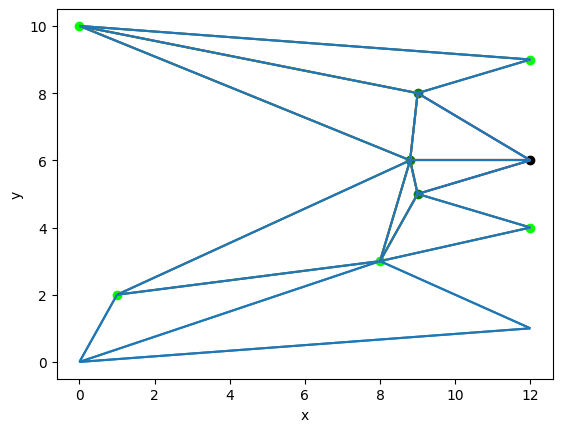

In [26]:
def find_neighbors_visualize(vertex_index, vertices, triangles, second_level=True):
    
    vis = Visualizer()
    vis.clear()
    
    neighbors_one_layer = set()
    neighbors_two_layers = set()


    for triangle in triangles:
        if vertex_index in triangle:
            neighbors_one_layer.update(triangle)
            vis.add_line_segment([vertices[triangle[0]], vertices[triangle[1]]], color = 'red')
            vis.add_line_segment([vertices[triangle[0]], vertices[triangle[2]]], color = 'red')
            vis.add_line_segment([vertices[triangle[2]], vertices[triangle[1]]], color = 'red')

    neighbors_one_layer.remove(vertex_index)

    if second_level:
        for neighbor in neighbors_one_layer:
            for triangle in triangles:
                if neighbor in triangle and vertex_index not in triangle:
                    neighbors_two_layers.update(triangle)
                    vis.add_line_segment([vertices[triangle[0]], vertices[triangle[1]]], color = 'orange')
                    vis.add_line_segment([vertices[triangle[0]], vertices[triangle[2]]], color = 'orange')
                    vis.add_line_segment([vertices[triangle[2]], vertices[triangle[1]]], color = 'orange')
    
        neighbors_two_layers -= neighbors_one_layer
        neighbors_two_layers.discard(vertex_index)
        
    polygon = convert_to_lines(vertices)
    vis.add_line_segment(polygon)
    for triangle in triangles:
        add = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        lines = convert_to_lines(add)
        vis.add_line_segment(lines)
    
    vis.add_point(vertices[vertex_index], color = "black")
    for point in neighbors_one_layer:
        vis.add_point(vertices[point],color = "green")
    for point in neighbors_two_layers:
        vis.add_point(vertices[point],color = "lime")  

    return [neighbors_one_layer, neighbors_two_layers], vis

def find_neighbors(vertex_index, triangles, second_level=True):
    neighbors_one_layer = set()
    neighbors_two_layers = set()

    for triangle in triangles:
        if vertex_index in triangle:
            neighbors_one_layer.update(triangle)
    neighbors_one_layer.remove(vertex_index)    
    
    if second_level:
        for neighbor in neighbors_one_layer:
            for triangle in triangles:
                if neighbor in triangle and vertex_index not in triangle:
                    neighbors_two_layers.update(triangle)
    
        neighbors_two_layers -= neighbors_one_layer
        neighbors_two_layers.discard(vertex_index)

    return [neighbors_one_layer, neighbors_two_layers]

vertices = points4
triangles = triangulation4
neighbours, vis = find_neighbors_visualize(5, vertices, triangles, True)
vis.show()
one_layer_neighbors, two_layers_neighbors = neighbours

print("Otoczenie jednowarstwowe wierzchołka", 5, "-", one_layer_neighbors)
print("Otoczenie dwuwarstwowe wierzchołka", 5, "-", two_layers_neighbors)

# Przeszukiwanie indycydentnych trójkątów w zwykłej strukturze

Otoczenie jednowarstwowe trójkąta 2 - {(0, 10, 2), (4, 9, 2)}
Otoczenie dwuwarstwowe trójkąta 2 - {(0, 1, 2), (5, 4, 9), (2, 3, 4)}


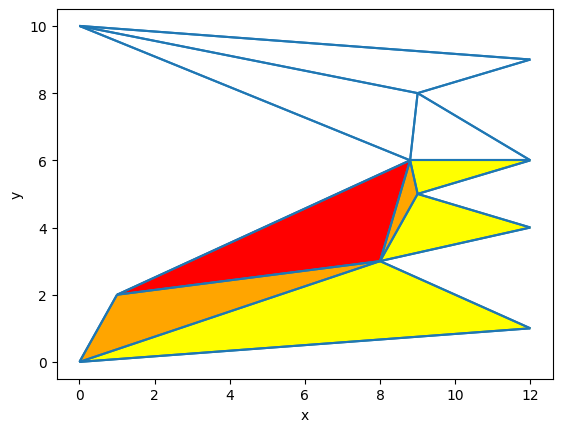

In [27]:
def are_triangles_incident(triangle1, triangle2):
    common_vertices = set(triangle1) & set(triangle2)
    return len(common_vertices) > 1


def find_triangle_neighbors(selected_index, triangles, second_level=True):
    neighbors_one_layer = set()
    neighbors_two_layers = set()

    selected_triangle = triangles[selected_index]
    
    for triangle in triangles:
        if selected_triangle != triangle and are_triangles_incident(selected_triangle, triangle):
            neighbors_one_layer.add(triangle)

    if second_level:
        for neighbor_triangle in neighbors_one_layer:
            for triangle in triangles:
                if triangle != selected_triangle and triangle != neighbor_triangle and are_triangles_incident(neighbor_triangle, triangle):
                    neighbors_two_layers.add(triangle)

    

    return [neighbors_one_layer, neighbors_two_layers]

def find_triangle_neighbors_visualize(selected_index, vertices, triangles, second_level=True):
    one_layer_neighbors, two_layers_neighbors = find_triangle_neighbors(selected_index, triangles, second_level)
    vis = Visualizer()
    vis.clear()
    polygon = convert_to_lines(points)
    vis.add_line_segment(polygon)
    for triangle in triangles:
        add = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        lines = convert_to_lines(add)
        vis.add_line_segment(lines)
    current_triangle=[]
    for point in triangles[selected_triangle]:
        current_triangle.append(vertices[point])
    vis.add_polygon(current_triangle,  color = "red")
    for triangle in one_layer_neighbors:
        current_triangle=[]
        for point in triangle:
            current_triangle.append(vertices[point])
        vis.add_polygon(current_triangle,  color = "orange")
    for triangle in two_layers_neighbors:
        current_triangle=[]
        for point in triangle:
            current_triangle.append(vertices[point])
        vis.add_polygon(current_triangle,  color = "yellow")
    return [one_layer_neighbors, two_layers_neighbors], vis


vertices = points4
triangles = triangulation4
selected_triangle = 2
neighbors, vis = find_triangle_neighbors_visualize(selected_triangle, vertices, triangles, selected_triangle)
vis.show()

one_layer_neighbors, two_layers_neighbors = neighbors

print("Otoczenie jednowarstwowe trójkąta", selected_triangle, "-", one_layer_neighbors)
print("Otoczenie dwuwarstwowe trójkąta", selected_triangle, "-", two_layers_neighbors)

# Przeszukiwanie incydentnych trójkątów by znaleźć ten zawierający wierzchołek, z użyciem prostej struktury

Trójkąt zawierający punkt 2 od trójkąta 8 - (4, 9, 2)


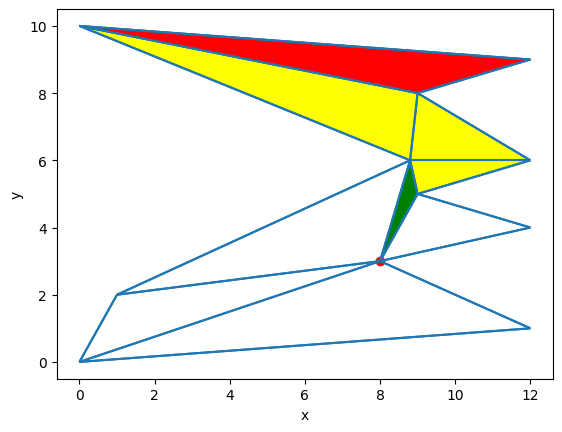

In [28]:
def are_triangles_incident(triangle1, triangle2):
    common_vertices = set(triangle1) & set(triangle2)
    return len(common_vertices) > 1


def find_triangle_containing_point(start_triangle, point, triangles, vis=None):
    current_triangle = triangles[start_triangle]
    visited_triangles = set()

    while current_triangle is not None:
        if current_triangle not in visited_triangles:
            visited_triangles.add(current_triangle)
            
            if vis is not None:
                path_triangle=[]
                for current_point in list(current_triangle):
                    path_triangle.append(vertices[current_point])
                    vis.add_polygon(path_triangle,  color = "yellow")
            
            current_vertices = set(current_triangle)
            if point in current_vertices:
                return current_triangle

            incident_triangles = [triangle for triangle in triangles if are_triangles_incident(current_triangle, triangle)]
            
            unvisited_triangles = [triangle for triangle in incident_triangles if triangle not in visited_triangles]

            if unvisited_triangles:
                current_triangle = unvisited_triangles[0]
                
            else:
                break
        else:
            break

    return None

def find_triangle_containing_point_visualize(start_triangle, point, vertices, triangles, vis):
    result_triangle = find_triangle_containing_point(start_triangle, point, triangles, vis)
    polygon = convert_to_lines(vertices)
    vis.add_line_segment(polygon)
    for triangle in triangles:
        add = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        lines = convert_to_lines(add)
        vis.add_line_segment(lines)
    print("Trójkąt zawierający punkt", target_point, "od trójkąta", start_triangle, "-", result_triangle)
    triangle=[]
    for point in triangles[start_triangle]:
        triangle.append(vertices[point])
    vis.add_polygon(triangle,  color = "red")
    
    triangle=[]
    for point in result_triangle:
        triangle.append(vertices[point])
    vis.add_polygon(triangle,  color = "green")
    
    vis.add_point(vertices[target_point], color = "red")
    

vertices = points4
triangles = triangulation4

start_triangle = 8
target_point = 2

vis = Visualizer()
find_triangle_containing_point_visualize(start_triangle, target_point, vertices, triangles, vis)
vis.show()

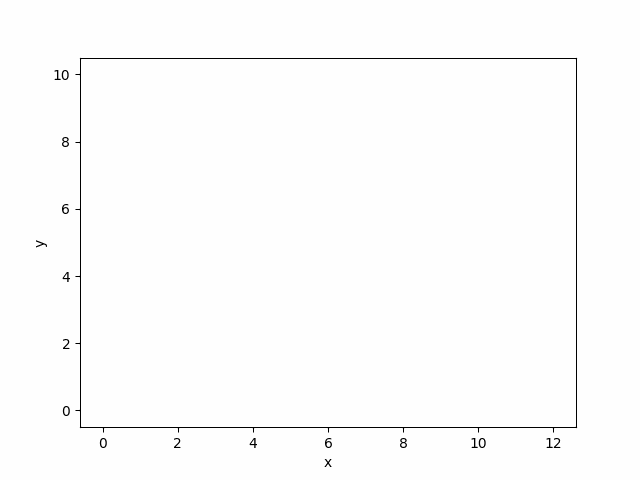

In [29]:
vis = Visualizer()
vis = draw_triangulation(points4, triangulation4, vis)
half_edges = HalfEdgeGraph(points4, triangulation4)
_, vis = half_edges.incidental_vertices_visualize(5, 2, vis)
vis.show_gif(500)

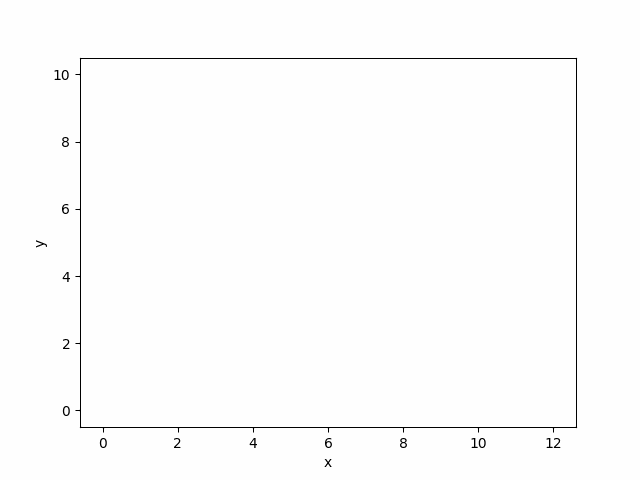

In [30]:
vis = Visualizer()
vis = draw_triangulation(points4, triangulation4, vis)
half_edges = HalfEdgeGraph(points4, triangulation4)
_, vis = half_edges.incidental_triangles_visualize(2, 2, vis)
vis.show_gif(500)

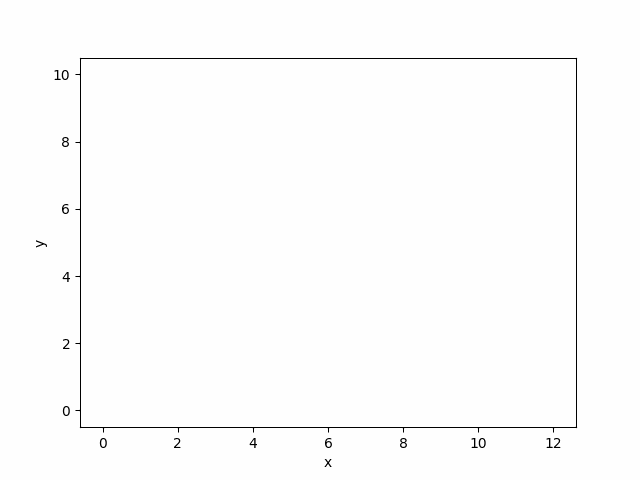

In [32]:
vis = Visualizer()
vis = draw_triangulation(points4, triangulation4, vis)
half_edges = HalfEdgeGraph(points4, triangulation4)
_, vis = half_edges.seek_vertex_visualize(2, 4, vis)
vis.show_gif(500)